## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regularizer=l2(1e-4)):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1), 
                                   kernel_regularizer = regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1), 
                                   kernel_regularizer = regularizer)(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULARIZERS = [l1, l2, l1_l2]

In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regularizer, ratio in itertools.product(REGULARIZERS, EXP):
    keras.backend.clear_session()
    print('Experiment with Regularizer= %s(%.6f)' % (regularizer, ratio))
    if regularizer == l1_l2:
        model = build_mlp(x_train.shape[1:], regularizer=regularizer(l1=ratio,l2=ratio))
    else:
        model = build_mlp(x_train.shape[1:], regularizer=regularizer(ratio))
    model.summary()
    
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),
              shuffle=True)
    
    #Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']
    
    exp_name_tag = 'exp_%s_%s' % (regularizer, str(ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regularizer= <function l1 at 0x00000144EB738C80>(0.010000)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 1000

50000/50000 [==============================] - 13s 253us/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 13s 251us/step - loss: 2.4626 - accuracy: 0.0963 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 12s 245us/step - loss: 2.4626 - accuracy: 0.0998 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regularizer= <function l1 at 0x00000144EB738C80>(0.000100)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________

50000/50000 [==============================] - 13s 257us/step - loss: 2.8306 - accuracy: 0.6179 - val_loss: 3.1779 - val_accuracy: 0.4986
Epoch 46/50
50000/50000 [==============================] - 11s 226us/step - loss: 2.7893 - accuracy: 0.6229 - val_loss: 3.0131 - val_accuracy: 0.5314
Epoch 47/50
50000/50000 [==============================] - 11s 217us/step - loss: 2.7556 - accuracy: 0.6193 - val_loss: 3.0050 - val_accuracy: 0.5242
Epoch 48/50
50000/50000 [==============================] - 12s 230us/step - loss: 2.7151 - accuracy: 0.6228 - val_loss: 2.9995 - val_accuracy: 0.5200
Epoch 49/50
50000/50000 [==============================] - 11s 227us/step - loss: 2.6772 - accuracy: 0.6237 - val_loss: 2.9740 - val_accuracy: 0.5186
Epoch 50/50
50000/50000 [==============================] - 11s 218us/step - loss: 2.6480 - accuracy: 0.6223 - val_loss: 2.9070 - val_accuracy: 0.5273
Experiment with Regularizer= <function l1 at 0x00000144EB738C80>(0.000000)
Model: "model_1"
____________________

50000/50000 [==============================] - 12s 244us/step - loss: 1.1981 - accuracy: 0.5796 - val_loss: 1.3579 - val_accuracy: 0.5157
Epoch 25/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.1862 - accuracy: 0.5831 - val_loss: 1.3600 - val_accuracy: 0.5165
Epoch 26/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.1715 - accuracy: 0.5886 - val_loss: 1.3865 - val_accuracy: 0.5132
Epoch 27/50
50000/50000 [==============================] - 12s 249us/step - loss: 1.1575 - accuracy: 0.5930 - val_loss: 1.3397 - val_accuracy: 0.5274
Epoch 28/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.1419 - accuracy: 0.5995 - val_loss: 1.3479 - val_accuracy: 0.5203
Epoch 29/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.1296 - accuracy: 0.6019 - val_loss: 1.3542 - val_accuracy: 0.5220
Epoch 30/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.1150 - accuracy: 0.6091 - va

Epoch 49/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.6134 - accuracy: 0.5238 - val_loss: 1.6651 - val_accuracy: 0.5067
Epoch 50/50
50000/50000 [==============================] - 13s 255us/step - loss: 1.6127 - accuracy: 0.5232 - val_loss: 1.7404 - val_accuracy: 0.4738
Experiment with Regularizer= <function l2 at 0x00000144EB7470D0>(0.000100)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
______________

50000/50000 [==============================] - 12s 249us/step - loss: 1.0747 - accuracy: 0.6717 - val_loss: 1.5900 - val_accuracy: 0.5129ss: 1.0737 
Epoch 46/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.0681 - accuracy: 0.6746 - val_loss: 1.4968 - val_accuracy: 0.5345
Epoch 47/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.0523 - accuracy: 0.6787 - val_loss: 1.6272 - val_accuracy: 0.5193
Epoch 48/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.0466 - accuracy: 0.6825 - val_loss: 1.5618 - val_accuracy: 0.5197
Epoch 49/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.0296 - accuracy: 0.6911 - val_loss: 1.5347 - val_accuracy: 0.5253
Epoch 50/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.0191 - accuracy: 0.6925 - val_loss: 1.5533 - val_accuracy: 0.5303
Experiment with Regularizer= <function l2 at 0x00000144EB7470D0>(0.000000)
Model: "model_1"
_________

50000/50000 [==============================] - 12s 248us/step - loss: 0.9596 - accuracy: 0.6632 - val_loss: 1.3568 - val_accuracy: 0.5300
Epoch 43/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.9472 - accuracy: 0.6684 - val_loss: 1.6094 - val_accuracy: 0.4788
Epoch 44/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.9360 - accuracy: 0.6731 - val_loss: 1.3596 - val_accuracy: 0.5333
Epoch 45/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.9214 - accuracy: 0.6784 - val_loss: 1.4027 - val_accuracy: 0.5227
Epoch 46/50
50000/50000 [==============================] - 12s 243us/step - loss: 0.9155 - accuracy: 0.6779 - val_loss: 1.3585 - val_accuracy: 0.5342
Epoch 47/50
50000/50000 [==============================] - 12s 247us/step - loss: 0.8963 - accuracy: 0.6849 - val_loss: 1.3891 - val_accuracy: 0.5272
Epoch 48/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.8831 - accuracy: 0.6895 - va

50000/50000 [==============================] - 12s 249us/step - loss: 1.0036 - accuracy: 0.6483 - val_loss: 1.3587 - val_accuracy: 0.5273
Epoch 40/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.9943 - accuracy: 0.6503 - val_loss: 1.3570 - val_accuracy: 0.5313
Epoch 41/50
50000/50000 [==============================] - 12s 239us/step - loss: 0.9825 - accuracy: 0.6563 - val_loss: 1.4144 - val_accuracy: 0.5106
Epoch 42/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.9693 - accuracy: 0.6595 - val_loss: 1.3817 - val_accuracy: 0.5152
Epoch 43/50
50000/50000 [==============================] - 12s 237us/step - loss: 0.9573 - accuracy: 0.6659 - val_loss: 1.3991 - val_accuracy: 0.5157
Epoch 44/50
50000/50000 [==============================] - 12s 248us/step - loss: 0.9415 - accuracy: 0.6703 - val_loss: 1.3746 - val_accuracy: 0.5252
Epoch 45/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.9351 - accuracy: 0.6728 - va

50000/50000 [==============================] - 14s 272us/step - loss: 2.4617 - accuracy: 0.0978 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 14s 282us/step - loss: 2.4617 - accuracy: 0.0987 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 14s 280us/step - loss: 2.4616 - accuracy: 0.0986 - val_loss: 2.4617 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 14s 280us/step - loss: 2.4616 - accuracy: 0.0984 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 14s 273us/step - loss: 2.4616 - accuracy: 0.0974 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 14s 275us/step - loss: 2.4616 - accuracy: 0.0978 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 14s 277us/step - loss: 2.4615 - accuracy: 0.1000 - va

Epoch 33/50
50000/50000 [==============================] - 14s 276us/step - loss: 3.3750 - accuracy: 0.5909 - val_loss: 3.5620 - val_accuracy: 0.5121
Epoch 34/50
50000/50000 [==============================] - 13s 268us/step - loss: 3.3237 - accuracy: 0.5942 - val_loss: 3.5013 - val_accuracy: 0.5260
Epoch 35/50
50000/50000 [==============================] - 13s 258us/step - loss: 3.2697 - accuracy: 0.5981 - val_loss: 3.4457 - val_accuracy: 0.5239
Epoch 36/50
50000/50000 [==============================] - 13s 264us/step - loss: 3.2209 - accuracy: 0.5998 - val_loss: 3.4134 - val_accuracy: 0.5204
Epoch 37/50
50000/50000 [==============================] - 13s 263us/step - loss: 3.1672 - accuracy: 0.6029 - val_loss: 3.3977 - val_accuracy: 0.5084
Epoch 38/50
50000/50000 [==============================] - 14s 275us/step - loss: 3.1190 - accuracy: 0.6040 - val_loss: 3.3570 - val_accuracy: 0.5067
Epoch 39/50
50000/50000 [==============================] - 13s 253us/step - loss: 3.0654 - accuracy:

Epoch 30/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.1229 - accuracy: 0.6041 - val_loss: 1.3304 - val_accuracy: 0.5304
Epoch 31/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.1097 - accuracy: 0.6086 - val_loss: 1.3360 - val_accuracy: 0.5305
Epoch 32/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.0961 - accuracy: 0.6164 - val_loss: 1.3261 - val_accuracy: 0.5317
Epoch 33/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.0813 - accuracy: 0.6198 - val_loss: 1.3350 - val_accuracy: 0.5318
Epoch 34/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.0663 - accuracy: 0.6237 - val_loss: 1.3237 - val_accuracy: 0.5373
Epoch 35/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.0602 - accuracy: 0.6263 - val_loss: 1.3507 - val_accuracy: 0.5282
Epoch 36/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.0454 - accuracy:

50000/50000 [==============================] - 14s 287us/step - loss: 1.1628 - accuracy: 0.5908 - val_loss: 1.3648 - val_accuracy: 0.5140
Epoch 28/50
50000/50000 [==============================] - 14s 286us/step - loss: 1.1502 - accuracy: 0.5941 - val_loss: 1.3542 - val_accuracy: 0.5189
Epoch 29/50
50000/50000 [==============================] - 14s 287us/step - loss: 1.1361 - accuracy: 0.6014 - val_loss: 1.3459 - val_accuracy: 0.5244
Epoch 30/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.1226 - accuracy: 0.6045 - val_loss: 1.3631 - val_accuracy: 0.5196
Epoch 31/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.1090 - accuracy: 0.6094 - val_loss: 1.4391 - val_accuracy: 0.5058
Epoch 32/50
50000/50000 [==============================] - 15s 298us/step - loss: 1.0963 - accuracy: 0.6131 - val_loss: 1.3332 - val_accuracy: 0.5286
Epoch 33/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.0842 - accuracy: 0.6192 - va

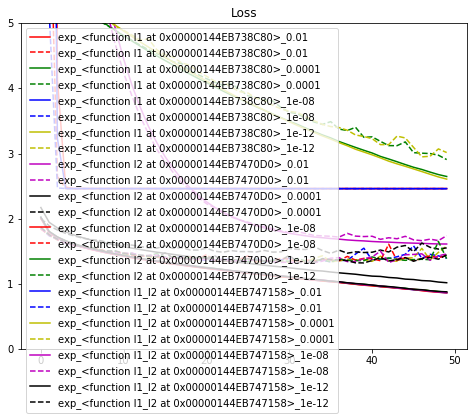

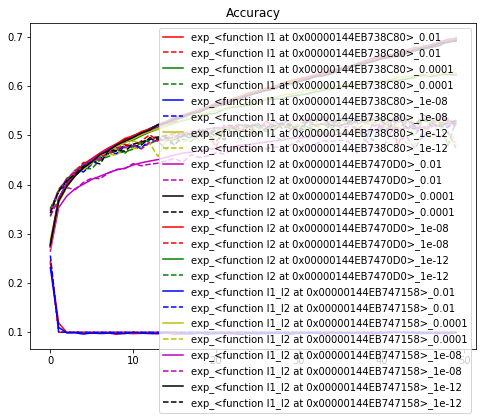

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%6])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%6])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%6])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%6])
plt.title("Accuracy")
plt.legend()
plt.show()